Author: Franziska

Codebase from Bhupen

# Finetune CNN model for the 4 classes dataset

## Setup and Libaries

In [42]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers, Sequential, regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from collections import defaultdict
import os
import cv2
import numpy as np
import pandas as pd
import sys
import random
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Load truncated images
Image.LOAD_TRUNCATED_IMAGES = True

# Set the path to the data directory
data_path = "../raw_data"

# Define labels dictionary
labels_dict = {'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}

## Data Exploration

### Count Image Shapes

In [2]:
def count_image_shapes(image_folder):
    """
    Count and print the number of images with each unique shape in the specified folder.

    Parameters:
    image_folder (str): The path to the folder containing the images.
    """
    shape_counts = defaultdict(int)  # Dictionary to store the count of each shape

    for image_name in os.listdir(image_folder):
        image_path = os.path.join(image_folder, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  # Load image with original channels
        if image is not None:
            shape_counts[image.shape] += 1
        else:
            print(f"Failed to load image: {image_name}")

    # Print the number of images with each shape
    for shape, count in shape_counts.items():
        print(f"Shape: {shape}, Count: {count}")

In [3]:
for key in labels_dict.keys():
    print(f"\n{key.capitalize()} images:")
    image_folder = os.path.join(data_path, 'satellite_images_4_classes', key)
    count_image_shapes(image_folder)


Cloudy images:
Shape: (256, 256, 3), Count: 1500

Desert images:
Shape: (256, 256, 3), Count: 1131

Green_area images:
Shape: (64, 64, 3), Count: 1500

Water images:
Shape: (64, 64, 3), Count: 1500


## Data Preperation and Preprocessing

### Load and Preprocess Data

In [4]:
def preprocess_image(image_path, target_size):
    """
    Preprocess an image by resizing and ensuring it has 3 channels.

    Parameters:
    image_path (str): The path to the image.
    target_size (tuple): The target size for the image (width, height).

    Returns:
    np.array: The preprocessed image array.
    """
    img = Image.open(image_path)
    if img.size == (256, 256):
        img = img.resize(target_size)
    img_array = np.asarray(img, dtype='uint8')[:,:,:3]  # Ensure RGB format
    return img_array

def load_data_4_classes(data_path, reduction_factor=10):
    """
    Load and preprocess images for 4 classes, rescaling high-resolution images
    and reducing dataset size for faster processing.

    Parameters:
    data_path (str): The base path to the data directory.
    reduction_factor (int): Factor by which to reduce the dataset size.

    Returns:
    np.array: Preprocessed image data.
    np.array: Corresponding labels.
    """
    labels_dict = {'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}
    target_size = (64, 64)
    X, y = [], []

    for label, class_idx in labels_dict.items():
        path_to_data = os.path.join(data_path, 'satellite_images_4_classes', label)
        images = np.array(os.listdir(path_to_data))
        selected_indices = np.random.choice(len(images), round(len(images) / reduction_factor), replace=False)
        selected_images = images[selected_indices]

        for image_name in selected_images:
            image_path = os.path.join(path_to_data, image_name)
            img_array = preprocess_image(image_path, target_size)
            X.append(img_array)
            y.append(class_idx)

    # Shuffle the dataset
    combined = list(zip(X, y))
    np.random.shuffle(combined)
    X, y = zip(*combined)

    return np.array(X), np.array(y)

In [5]:
# Load data
X, y = load_data_4_classes(data_path, reduction_factor=1)
print(f'Shape of X : {X.shape}')

Shape of X : (5631, 64, 64, 3)


### Checking for Imbalance

In [6]:
# Checking for class imbalance
for i, label in enumerate(labels_dict):
    print(f'Fraction of class {label} : {len(y[y==i]) / len(y)}')

Fraction of class cloudy : 0.2663825253063399
Fraction of class desert : 0.20085242408098028
Fraction of class green_area : 0.2663825253063399
Fraction of class water : 0.2663825253063399


### Train-Test Split

In [7]:
# Split data
split_frac = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_frac)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (4504, 64, 64, 3), Test shape: (1127, 64, 64, 3)


### Normalization and One-Hot Encoding

In [8]:
# Normalization
X_train_rescaled = X_train / 255
X_test_rescaled = X_test / 255

# One-hot encoding the labels
n_labels = len(set(y))
y_train = to_categorical(y_train, n_labels)
y_test = to_categorical(y_test, n_labels)


## Model Building

### Model Initializing

In [9]:
def initialize_model(input_shape, n_labels):
    """
    Initialize and compile a CNN model.

    Parameters:
    input_shape (tuple): The shape of the input data.
    n_labels (int): The number of output classes.

    Returns:
    Sequential: The compiled CNN model.
    """
    model = Sequential()

    model.add(layers.Conv2D(16, (4, 4), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(n_labels, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [35]:
def initialize_model(input_shape, n_labels):
    """
    Initialize and compile a CNN model with regularization, dropout, and batch normalization.

    Parameters:
    input_shape (tuple): The shape of the input data.
    n_labels (int): The number of output classes.

    Returns:
    Sequential: The compiled CNN model.
    """
    model = Sequential()

    model.add(layers.Conv2D(16, (4, 4), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(n_labels, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [36]:
# Initialize the model
input_shape = (X_train_rescaled.shape[1], X_train_rescaled.shape[2], X_train_rescaled.shape[3])
model = initialize_model(input_shape, n_labels)
model.summary()

/home/franziska/.pyenv/versions/3.10.6/envs/EnviroClass/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 16)     │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 61, 61, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 15, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │        50,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,252 (434.58 KB)

 Trainable params: 111,028 (433.70 KB)

 Non-trainable params: 224 (896.00 B)

## Model Training and Evaluation

### Training the Model

In [56]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Überwache die Validierungsverluste
    patience=10,          # Training wird nach 3 Epochen ohne Verbesserung gestoppt
    restore_best_weights=True  # Beste Gewichte wiederherstellen
)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',  # Dateipfad zum Speichern des besten Modells
    monitor='val_loss',        # Überwache die Validierungsverluste
    save_best_only=True        # Nur das beste Modell speichern
)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.00001,
    verbose=1
)

# Train the model with the additional callback
history = model.fit(
    X_train_rescaled,
    y_train,
    validation_split=0.2,
    epochs=500,
    #batch_size=10,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/500
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8844 - loss: 0.4193

361/361 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.8844 - loss: 0.4193 - val_accuracy: 0.8757 - val_loss: 0.3057 - learning_rate: 1.0000e-05
Epoch 2/500
360/361 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8889 - loss: 0.4531

361/361 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.8889 - loss: 0.4531 - val_accuracy: 0.9012 - val_loss: 0.2430 - learning_rate: 1.0000e-05
Epoch 3/500
361/361 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.8831 - loss: 0.4681 - val_accuracy: 0.8812 - val_loss: 0.2709 - learning_rate: 1.0000e-05
Epoch 4/500
360/361 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8757 - loss: 0.4399

361/361 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8757 - loss: 0.4399 - val_accuracy: 0.9101 - val_loss: 0.2306 - learning_rate: 1.0000e-05
Epoch 5/500
361/361 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.8910 - loss: 0.4015 - val_accuracy: 0.8968 - val_loss: 0.2516 - learning_rate: 1.0000e-05
Epoch 6/500
361/361 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8801 - loss: 0.4797 - val_accuracy: 0.9012 - val_loss: 0.2580 - learning_rate: 1.0000e-05
Epoch 7/500
361/361 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.9048 - loss: 0.3664 - val_accuracy: 0.8835 - val_loss: 0.2960 - learning_rate: 1.0000e-05
Epoch 8/500
361/361 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.8977 - loss: 0.4128 - val_accuracy: 0.8901 - val_loss: 0.2706 - learning_rate: 1.0000e-05
Epoch 9/500
361/361 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.8964 - loss: 0.3792 - val_accuracy: 0.9001 - val_loss: 0.2514 - learning_rate: 1.0000e-05
Epoch 10/500
361/361 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - 

### Plot Training History

In [57]:
def plot_history(history):
    """
    Plot the training history of the model.

    Parameters:
    history (History): The history object returned by model.fit().
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='val')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy')
    ax2.plot(history.history['val_accuracy'], label='val accuracy')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()

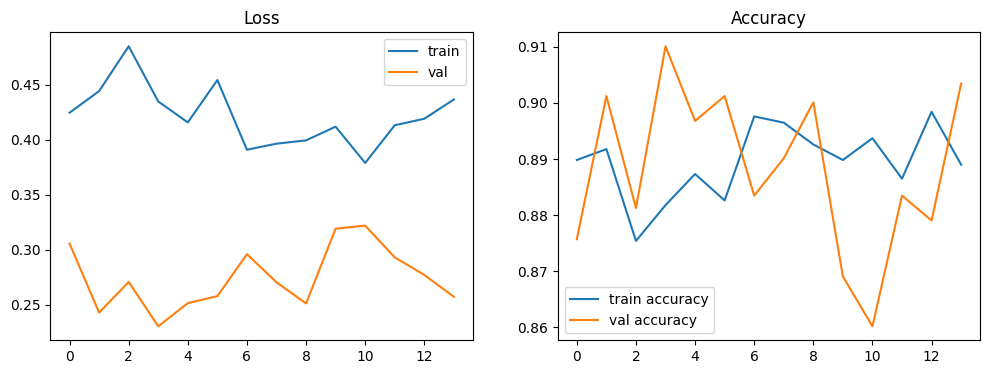

In [58]:
# Plot training history
plot_history(history)

## Model Evaluation

### Classification Report and Confusion Matrix

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Classification Report:
              precision    recall  f1-score   support

      cloudy       0.96      0.99      0.98       311
      desert       1.00      1.00      1.00       243
  green_area       0.99      0.98      0.98       304
       water       0.97      0.95      0.96       269

    accuracy                           0.98      1127
   macro avg       0.98      0.98      0.98      1127
weighted avg       0.98      0.98      0.98      1127



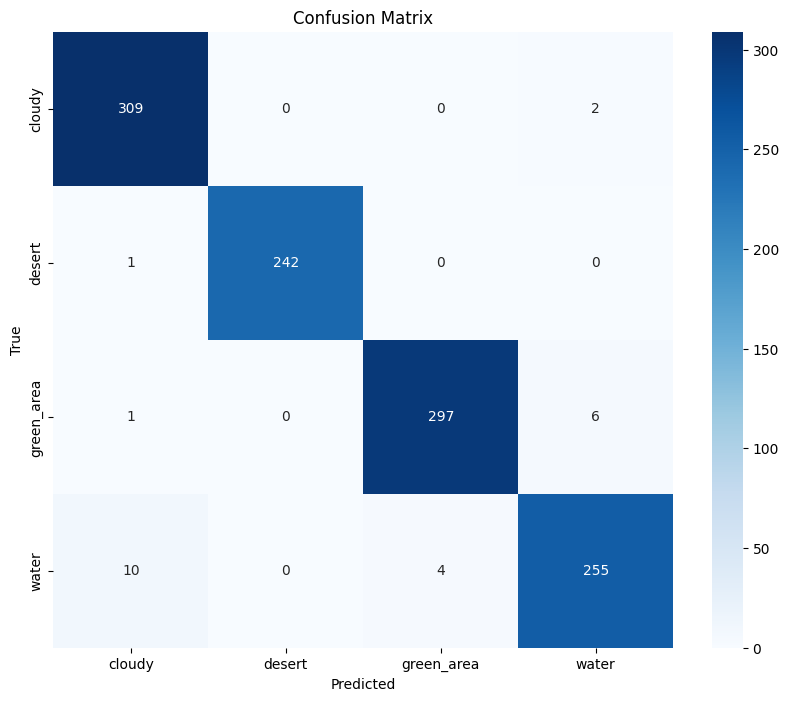

In [46]:
# Evaluate model
y_pred = model.predict(X_test_rescaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(labels_dict.keys())))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(labels_dict.keys()), yticklabels=list(labels_dict.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Save Model

In [48]:
# Save the final model
model_path = f'../models/model_acc_{max(history.history["val_accuracy"]):.4f}.keras'
model.save(model_path)